# **Food Calories Estimation Using Image Processing**
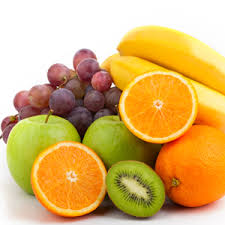

+ ###  Problem
 The problem can be simply stated as, given a set of food images with calibration object thumb with the food name and an unlabeled set of food images from the same group of food, identify food and estimate food volume and calories intake.
+ ### Objectives
 1.	To detect food type by using Convolutional Neural Network (CNN)
 2.	To estimate food weight and calories of food


In [2]:
!git clone https://github.com/ultralytics/yolov5  # clone repo
%cd yolov5

Cloning into 'yolov5'...
remote: Enumerating objects: 16075, done.
remote: Counting objects: 100% (19/19), done.
remote: Compressing objects: 100% (19/19), done.
remote: Total 16075 (delta 7), reused 4 (delta 0), pack-reused 16056
Receiving objects: 100% (16075/16075), 14.62 MiB | 15.47 MiB/s, done.
Resolving deltas: 100% (11039/11039), done.
/content/yolov5


In [8]:
# install dependencies as necessary
!pip install -qr requirements.txt  # install dependencies (ignore errors)
import torch
!pip install utils.google_utils
from IPython.display import Image, clear_output  # to display images

# clear_output()
print('Setup complete. Using torch %s %s' % (torch.__version__, torch.cuda.get_device_properties(0) if torch.cuda.is_available() else 'CPU'))

ERROR: Could not find a version that satisfies the requirement utils.google_utils (from versions: none)
ERROR: No matching distribution found for utils.google_utils
Setup complete. Using torch 2.1.0+cu118 _CudaDeviceProperties(name='Tesla T4', major=7, minor=5, total_memory=15101MB, multi_processor_count=40)


In [ ]:

#follow the link below to get your download code from from Roboflow
!pip install -q roboflow
from roboflow import Roboflow
api_key='r9Ty2lZkOKX6d8cztbYI'
rf = Roboflow(api_key=api_key,model_format="yolov5", notebook="roboflow-yolov5")


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.3/63.3 kB 1.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 178.7/178.7 kB 4.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.8/58.8 kB 6.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.1/49.1 MB 19.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 67.8/67.8 kB 8.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 72.2/72.2 kB 10.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.5/54.5 kB 7.6 MB/s eta 0:00:00


In [5]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
%cd /content/yolov5

/content/yolov5


In [ ]:
%cat "/content/drive/MyDrive/Fruits  and Thumb detection.v5-v5-for-yolov4-darknet.yolov5pytorch/data.yaml"


train: "/content/drive/MyDrive/Fruits  and Thumb detection.v5-v5-for-yolov4-darknet.yolov5pytorch/train/images"
val: "/content/drive/MyDrive/Fruits  and Thumb detection.v5-v5-for-yolov4-darknet.yolov5pytorch/valid/images"
test: '/content/drive/MyDrive/Fruits  and Thumb detection.v5-v5-for-yolov4-darknet.yolov5pytorch/test/images/'
nc: 8
names: ['Apple', 'Banana', 'Carrot', 'Onion', 'Orange', 'Qiwi', 'Tomato', 'thumb']

In [ ]:
import yaml
with open("/content/drive/MyDrive/Fruits  and Thumb detection.v5-v5-for-yolov4-darknet.yolov5pytorch/data.yaml", 'r') as stream:
    num_classes = str(yaml.safe_load(stream)['nc'])

In [ ]:
print(num_classes)

8


In [ ]:
%cat /content/yolov5/models/yolov5s.yaml

# YOLOv5 🚀 by Ultralytics, AGPL-3.0 license

# Parameters
nc: 80  # number of classes
depth_multiple: 0.33  # model depth multiple
width_multiple: 0.50  # layer channel multiple
anchors:
  - [10,13, 16,30, 33,23]  # P3/8
  - [30,61, 62,45, 59,119]  # P4/16
  - [116,90, 156,198, 373,326]  # P5/32

# YOLOv5 v6.0 backbone
backbone:
  # [from, number, module, args]
  [[-1, 1, Conv, [64, 6, 2, 2]],  # 0-P1/2
   [-1, 1, Conv, [128, 3, 2]],  # 1-P2/4
   [-1, 3, C3, [128]],
   [-1, 1, Conv, [256, 3, 2]],  # 3-P3/8
   [-1, 6, C3, [256]],
   [-1, 1, Conv, [512, 3, 2]],  # 5-P4/16
   [-1, 9, C3, [512]],
   [-1, 1, Conv, [1024, 3, 2]],  # 7-P5/32
   [-1, 3, C3, [1024]],
   [-1, 1, SPPF, [1024, 5]],  # 9
  ]

# YOLOv5 v6.0 head
head:
  [[-1, 1, Conv, [512, 1, 1]],
   [-1, 1, nn.Upsample, [None, 2, 'nearest']],
   [[-1, 6], 1, Concat, [1]],  # cat backbone P4
   [-1, 3, C3, [512, False]],  # 13

   [-1, 1, Conv, [256, 1, 1]],
   [-1, 1, nn.Upsample, [None, 2, 'nearest']],
   [[-1, 4], 1, Concat, [1]

In [ ]:
from IPython.core.magic import register_line_cell_magic

@register_line_cell_magic
def writetemplate(line, cell):
    with open(line, 'w') as f:
        f.write(cell.format(**globals()))


In [ ]:
%cat /content/yolov5/models/yolov5s.yaml

# YOLOv5 🚀 by Ultralytics, AGPL-3.0 license

# Parameters
nc: 80  # number of classes
depth_multiple: 0.33  # model depth multiple
width_multiple: 0.50  # layer channel multiple
anchors:
  - [10,13, 16,30, 33,23]  # P3/8
  - [30,61, 62,45, 59,119]  # P4/16
  - [116,90, 156,198, 373,326]  # P5/32

# YOLOv5 v6.0 backbone
backbone:
  # [from, number, module, args]
  [[-1, 1, Conv, [64, 6, 2, 2]],  # 0-P1/2
   [-1, 1, Conv, [128, 3, 2]],  # 1-P2/4
   [-1, 3, C3, [128]],
   [-1, 1, Conv, [256, 3, 2]],  # 3-P3/8
   [-1, 6, C3, [256]],
   [-1, 1, Conv, [512, 3, 2]],  # 5-P4/16
   [-1, 9, C3, [512]],
   [-1, 1, Conv, [1024, 3, 2]],  # 7-P5/32
   [-1, 3, C3, [1024]],
   [-1, 1, SPPF, [1024, 5]],  # 9
  ]

# YOLOv5 v6.0 head
head:
  [[-1, 1, Conv, [512, 1, 1]],
   [-1, 1, nn.Upsample, [None, 2, 'nearest']],
   [[-1, 6], 1, Concat, [1]],  # cat backbone P4
   [-1, 3, C3, [512, False]],  # 13

   [-1, 1, Conv, [256, 1, 1]],
   [-1, 1, nn.Upsample, [None, 2, 'nearest']],
   [[-1, 4], 1, Concat, [1]

In [ ]:
%%writetemplate /content/yolov5/models/custom_yolov5s.yaml

# parameters
nc: {num_classes}  # number of classes
depth_multiple: 0.33  # model depth multiple
width_multiple: 0.50  # layer channel multiple

# anchors
anchors:
  - [10,13, 16,30, 33,23]  # P3/8
  - [30,61, 62,45, 59,119]  # P4/16
  - [116,90, 156,198, 373,326]  # P5/32

# YOLOv5 backbone
backbone:
  # [from, number, module, args]
  [[-1, 1, Focus, [64, 3]],  # 0-P1/2
   [-1, 1, Conv, [128, 3, 2]],  # 1-P2/4
   [-1, 3, BottleneckCSP, [128]],
   [-1, 1, Conv, [256, 3, 2]],  # 3-P3/8
   [-1, 9, BottleneckCSP, [256]],
   [-1, 1, Conv, [512, 3, 2]],  # 5-P4/16
   [-1, 9, BottleneckCSP, [512]],
   [-1, 1, Conv, [1024, 3, 2]],  # 7-P5/32
   [-1, 1, SPP, [1024, [5, 9, 13]]],
   [-1, 3, BottleneckCSP, [1024, False]],  # 9
  ]

# YOLOv5 head
head:
  [[-1, 1, Conv, [512, 1, 1]],
   [-1, 1, nn.Upsample, [None, 2, 'nearest']],
   [[-1, 6], 1, Concat, [1]],  # cat backbone P4
   [-1, 3, BottleneckCSP, [512, False]],  # 13

   [-1, 1, Conv, [256, 1, 1]],
   [-1, 1, nn.Upsample, [None, 2, 'nearest']],
   [[-1, 4], 1, Concat, [1]],  # cat backbone P3
   [-1, 3, BottleneckCSP, [256, False]],  # 17 (P3/8-small)

   [-1, 1, Conv, [256, 3, 2]],
   [[-1, 14], 1, Concat, [1]],  # cat head P4
   [-1, 3, BottleneckCSP, [512, False]],  # 20 (P4/16-medium)

   [-1, 1, Conv, [512, 3, 2]],
   [[-1, 10], 1, Concat, [1]],  # cat head P5
   [-1, 3, BottleneckCSP, [1024, False]],  # 23 (P5/32-large)

   [[17, 20, 23], 1, Detect, [nc, anchors]],  # Detect(P3, P4, P5)
  ]

In [ ]:
pip install wandb

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 12.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 248.6/248.6 kB 16.2 MB/s eta 0:00:00


In [ ]:
%%time
%cd /content/yolov5/
!python train.py --img 1280 --batch 128 --epochs 150 --data "/content/drive/MyDrive/Fruits  and Thumb detection.v5-v5-for-yolov4-darknet.yolov5pytorch/data.yaml" --cfg /content/yolov5/models/custom_yolov5m.yaml --weights '' --name yolov5m_results --cache


/content/yolov5
2023-11-19 17:09:03.136987: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-11-19 17:09:03.137046: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-11-19 17:09:03.137102: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-11-19 17:09:03.149299: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-11-19 17:09:04.585574: W tens

In [ ]:
# train yolov5s on custom data for 100 epochs
# time its performance
%%time
%cd /content/yolov5/
!python train.py --img 640 --batch 16 --epochs 100 --data "/content/drive/MyDrive/Fruits  and Thumb detection.v5-v5-for-yolov4-darknet.yolov5pytorch/data.yaml" --cfg ./models/custom_yolov5s.yaml

/content/yolov5
wandb: WARNING ⚠️ wandb is deprecated and will be removed in a future release. See supported integrations at https://github.com/ultralytics/yolov5#integrations.
2023-11-19 17:40:49.101563: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-11-19 17:40:49.101610: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-11-19 17:40:49.101671: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
wandb: (1) Create a W&B account
wandb: (2) Use an existing W&B account
wandb: (3) Don't visualize my results
wandb: Enter your choice: (30 second timeout) 2
wandb: You chose 'Use an exi

In [ ]:
%load_ext tensorboard
%tensorboard --logdir runs

<IPython.core.display.Javascript object>

GROUND TRUTH TRAINING DATA:


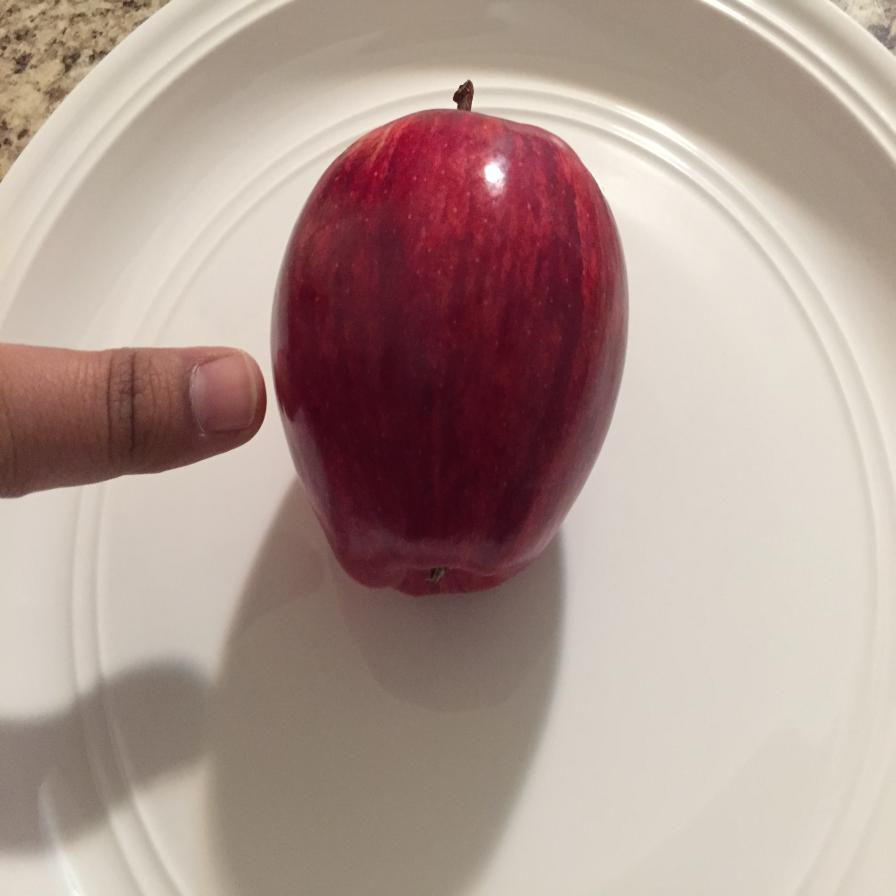

In [ ]:
# first, display our ground truth data
print("GROUND TRUTH TRAINING DATA:")
Image(filename='/content/drive/MyDrive/Fruits  and Thumb detection.v5-v5-for-yolov4-darknet.yolov5pytorch/test/images/Apple_27_jpg.rf.29688965e78d5d2dc6b93a6ec27ce53b.jpg', width=900)


In [ ]:

# trained weights are saved by default in our weights folder
%ls runs/

train/


In [ ]:
%ls /content/yolov5/runs/train/exp/weights

best.pt  last.pt


In [ ]:
%cd /content/yolov5/
!python detect.py --weights '/content/yolov5/runs/train/exp/weights/best.pt' --img 640 --conf 0.4 --source '/content/drive/MyDrive/Fruits  and Thumb detection.v5-v5-for-yolov4-darknet.yolov5pytorch/train/images/'

/content/yolov5
detect: weights=['/content/yolov5/runs/train/exp/weights/best.pt'], source=/content/drive/MyDrive/Fruits  and Thumb detection.v5-v5-for-yolov4-darknet.yolov5pytorch/train/images/, data=data/coco128.yaml, imgsz=[640, 640], conf_thres=0.4, iou_thres=0.45, max_det=1000, device=, view_img=False, save_txt=False, save_csv=False, save_conf=False, save_crop=False, nosave=False, classes=None, agnostic_nms=False, augment=False, visualize=False, update=False, project=runs/detect, name=exp, exist_ok=False, line_thickness=3, hide_labels=False, hide_conf=False, half=False, dnn=False, vid_stride=1
YOLOv5 🚀 v7.0-242-gb378d10 Python-3.10.12 torch-2.1.0+cu118 CUDA:0 (Tesla T4, 15102MiB)

Fusing layers... 
custom_YOLOv5s summary: 182 layers, 7265397 parameters, 0 gradients
image 1/756 /content/drive/MyDrive/Fruits  and Thumb detection.v5-v5-for-yolov4-darknet.yolov5pytorch/train/images/Apple_0_jpg.rf.07138f24ae4ff4f30851a3a1de3aa9dd.jpg: 640x640 1 Apple, 1 thumb, 12.5ms
image 2/756 /conte

In [ ]:
import glob
from IPython.display import Image, display

for imageName in glob.glob('/content/yolov5/runs/detect/exp/*.jpg'): #assuming JPG
    display(Image(filename=imageName))
    print("\n")

In [ ]:
mkdir -p /content/drive/MyDrive/Colab\ Notebooks/fooddetectionyolo

In [ ]:
cp -av /content/yolov5/* /content/drive/MyDrive/Colab\ Notebooks/fooddetectionyolo


'/content/yolov5/benchmarks.py' -> '/content/drive/MyDrive/Colab Notebooks/fooddetectionyolo/benchmarks.py'
'/content/yolov5/CITATION.cff' -> '/content/drive/MyDrive/Colab Notebooks/fooddetectionyolo/CITATION.cff'
'/content/yolov5/classify' -> '/content/drive/MyDrive/Colab Notebooks/fooddetectionyolo/classify'
'/content/yolov5/classify/predict.py' -> '/content/drive/MyDrive/Colab Notebooks/fooddetectionyolo/classify/predict.py'
'/content/yolov5/classify/train.py' -> '/content/drive/MyDrive/Colab Notebooks/fooddetectionyolo/classify/train.py'
'/content/yolov5/classify/tutorial.ipynb' -> '/content/drive/MyDrive/Colab Notebooks/fooddetectionyolo/classify/tutorial.ipynb'
'/content/yolov5/classify/val.py' -> '/content/drive/MyDrive/Colab Notebooks/fooddetectionyolo/classify/val.py'
'/content/yolov5/CONTRIBUTING.md' -> '/content/drive/MyDrive/Colab Notebooks/fooddetectionyolo/CONTRIBUTING.md'
'/content/yolov5/data' -> '/content/drive/MyDrive/Colab Notebooks/fooddetectionyolo/data'
'/content/

In [ ]:
!python detect.py --weights '/content/drive/MyDrive/Colab Notebooks/fooddetectionyolo/runs/train/exp/weights/best.pt' --img 640 --conf 0.4 --source '/content/drive/MyDrive/Fruits  and Thumb detection.v5-v5-for-yolov4-darknet.yolov5pytorch/test/images'


detect: weights=['/content/drive/MyDrive/Colab Notebooks/fooddetectionyolo/runs/train/exp/weights/best.pt'], source=/content/drive/MyDrive/Fruits  and Thumb detection.v5-v5-for-yolov4-darknet.yolov5pytorch/train/images, data=data/coco128.yaml, imgsz=[640, 640], conf_thres=0.4, iou_thres=0.45, max_det=1000, device=, view_img=False, save_txt=False, save_csv=False, save_conf=False, save_crop=False, nosave=False, classes=None, agnostic_nms=False, augment=False, visualize=False, update=False, project=runs/detect, name=exp, exist_ok=False, line_thickness=3, hide_labels=False, hide_conf=False, half=False, dnn=False, vid_stride=1
YOLOv5 🚀 v7.0-243-g7c54e5d Python-3.10.12 torch-2.1.0+cu118 CUDA:0 (Tesla T4, 15102MiB)

Fusing layers... 
custom_YOLOv5s summary: 182 layers, 7265397 parameters, 0 gradients
image 1/756 /content/drive/MyDrive/Fruits  and Thumb detection.v5-v5-for-yolov4-darknet.yolov5pytorch/train/images/Apple_0_jpg.rf.07138f24ae4ff4f30851a3a1de3aa9dd.jpg: 640x640 1 Apple, 1 thumb, 1

In [ ]:
import glob
from IPython.display import Image, display
for imageName in glob.glob('/content/drive/MyDrive/Colab Notebooks/fooddetectionyolo/runs/detect/exp/*.jpg'): #assuming JPG
    display(Image(filename=imageName))
    print("\n")


AA


In [ ]:
!python detect.py --weights '/content/drive/MyDrive/Colab Notebooks/fooddetectionyolo/runs/train/exp/weights/best.pt' --img 640 --conf 0.4 --source '/content/drive/MyDrive/Fruits  and Thumb detection.v5-v5-for-yolov4-darknet.yolov5pytorch/test/images'

detect: weights=['/content/drive/MyDrive/Colab Notebooks/fooddetectionyolo/runs/train/exp/weights/best.pt'], source=/content/drive/MyDrive/Fruits  and Thumb detection.v5-v5-for-yolov4-darknet.yolov5pytorch/test/images, data=data/coco128.yaml, imgsz=[640, 640], conf_thres=0.4, iou_thres=0.45, max_det=1000, device=, view_img=False, save_txt=False, save_csv=False, save_conf=False, save_crop=False, nosave=False, classes=None, agnostic_nms=False, augment=False, visualize=False, update=False, project=runs/detect, name=exp, exist_ok=False, line_thickness=3, hide_labels=False, hide_conf=False, half=False, dnn=False, vid_stride=1
YOLOv5 🚀 v7.0-243-g7c54e5d Python-3.10.12 torch-2.1.0+cu118 CUDA:0 (Tesla T4, 15102MiB)

Fusing layers... 
custom_YOLOv5s summary: 182 layers, 7265397 parameters, 0 gradients
image 1/29 /content/drive/MyDrive/Fruits  and Thumb detection.v5-v5-for-yolov4-darknet.yolov5pytorch/test/images/Apple_27_jpg.rf.29688965e78d5d2dc6b93a6ec27ce53b.jpg: 640x640 1 Apple, 1 thumb, 12.

In [ ]:
import torch
from models.yolo import Model
from utils.general import check_requirements, check_git_status
from IPython.display import Image, display



In [ ]:
!git clone https://github.com/ultralytics/yolov5  # clone repo
%cd yolov5
!pip install -qr requirements.txt  # install dependencies (ignore errors)



fatal: destination path 'yolov5' already exists and is not an empty directory.
/content/yolov5/yolov5


In [3]:
import torch
from models.experimental import attempt_load
from utils.general import check_img_size, non_max_suppression, scale_coords
from pathlib import Path
import cv2

# Set the device (you can use 'cuda' if you have a GPU, otherwise 'cpu')
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Load the model
model = attempt_load('/content/drive/MyDrive/Colab Notebooks/fooddetectionyolo/runs/train/exp/weights/best.pt', map_location=device)
stride = int(model.stride.max())  # model stride

# Set the model to evaluation mode
model.eval()

# Define a function for inference
def inference(image_path, conf_thres=0.4):
    img0 = cv2.imread(image_path)  # Load image
    img = img0.copy()

    # Padded resize
    img = letterbox(img, new_shape=640)[0]

    # Convert to BGR to RGB
    img = img[:, :, ::-1].transpose(2, 0, 1)

    # Normalize
    img = torch.from_numpy(img).to(device)
    img = img.float() / 255.0

    # Check if the image size is a multiple of stride
    img_size = check_img_size(640, s=stride)

    # Inference
    img = img.unsqueeze(0)
    pred = model(img, augment=False)[0]

    # Post-process results
    pred = non_max_suppression(pred, conf_thres, 0.5)

    # Process detections
    for det in pred[0]:
        if len(det):
            det[:, :4] = scale_coords(img.shape[2:], det[:, :4], img0.shape).round()

            # Draw bounding boxes and labels
            for *xyxy, conf, cls in reversed(det):
                # Draw bounding box
                cv2.rectangle(img0, (int(xyxy[0]), int(xyxy[1])), (int(xyxy[2]), int(xyxy[3])), (0, 255, 0), 2)

                # Display label and confidence
                label = f'{model.names[int(cls)]} {conf:.2f}'
                cv2.putText(img0, label, (int(xyxy[0]), int(xyxy[1] - 10)), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 255, 255), 2)

    # Display the image with detections
    cv2.imshow('Inference', img0)
    cv2.waitKey(0)
    cv2.destroyAllWindows()

# Demo with a sample image
image_path_demo = '/content/drive/MyDrive/Fruits and Thumb detection.v5-v5-for-yolov4-darknet.yolov5pytorch/test/images/sample.jpg'
inference(image_path_demo)



ImportError: ignored

In [ ]:
import torch
from models.yolo import Model
num_classes_str = str(num_classes)

# Load your custom YOLO model
model = Model('/content/drive/MyDrive/Colab Notebooks/fooddetectionyolo/models/custom_yolov5s.yaml', ch=3, nc=num_classes_str)  # Adjust 'ch' based on the number of channels in your input images

# Load the trained weights
model.load_state_dict(torch.load('/content/yolov5/runs/train/exp/weights/best.pt')['model'])

# Set the model to evaluation mode
model.eval()

# Optional: Move the model to GPU if available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)

# Now, you can use this 'model' for inference on new images


TypeError: ignored

In [11]:
from google.colab import files

files.download("/content/drive/MyDrive/Colab Notebooks/fooddetectionyolo/runs/detect/exp/results")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [18]:
from google.colab import files
import shutil

shutil.make_archive("/content/drive/MyDrive/Colab Notebooks/fooddetectionyolo/runs/detect/exp/results", 'zip', "/content/my_folder")
files.download("/content/drive/MyDrive/Colab Notebooks/fooddetectionyolo/runs/detect/exp/results.zip")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>